# 통계세미나 HW1

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


---
# 시도표, ACP, PACF

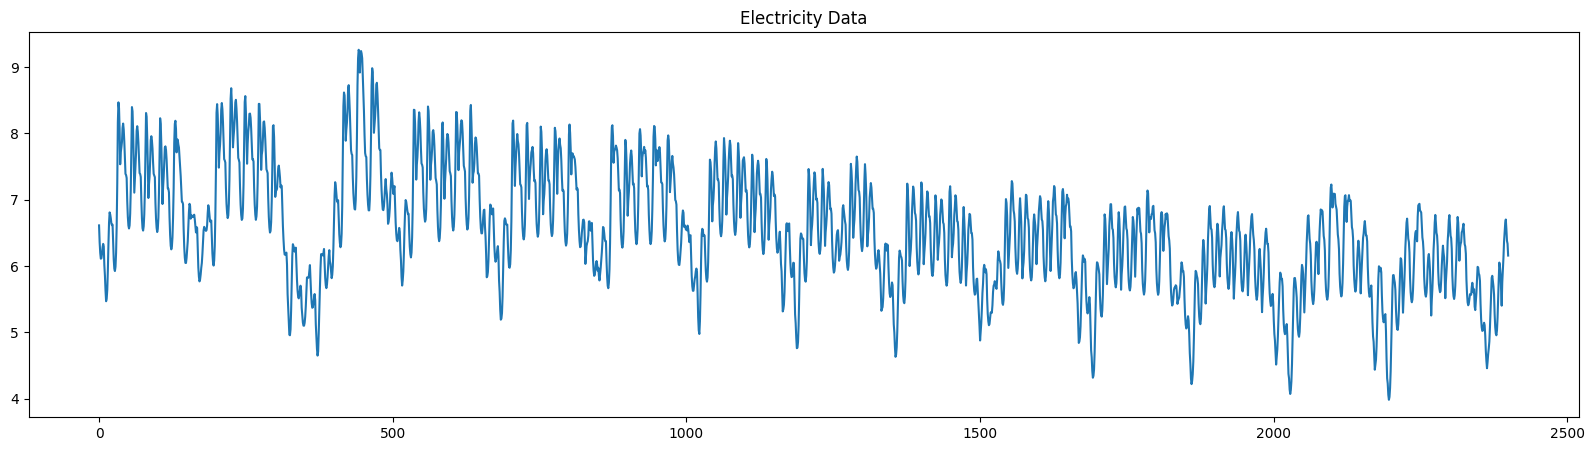

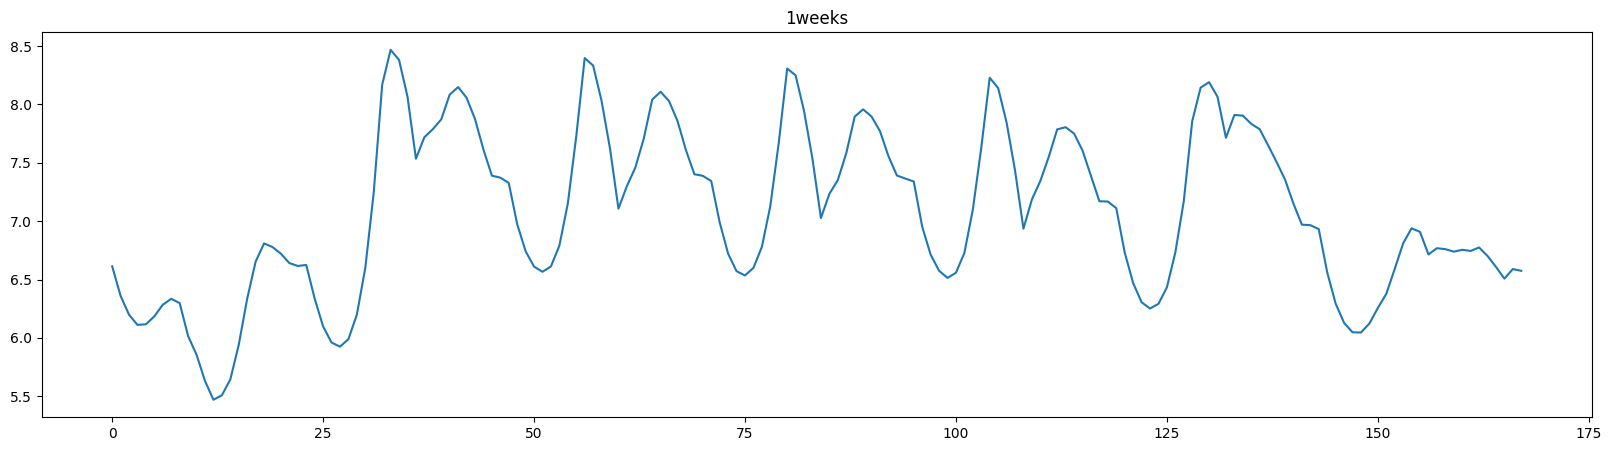

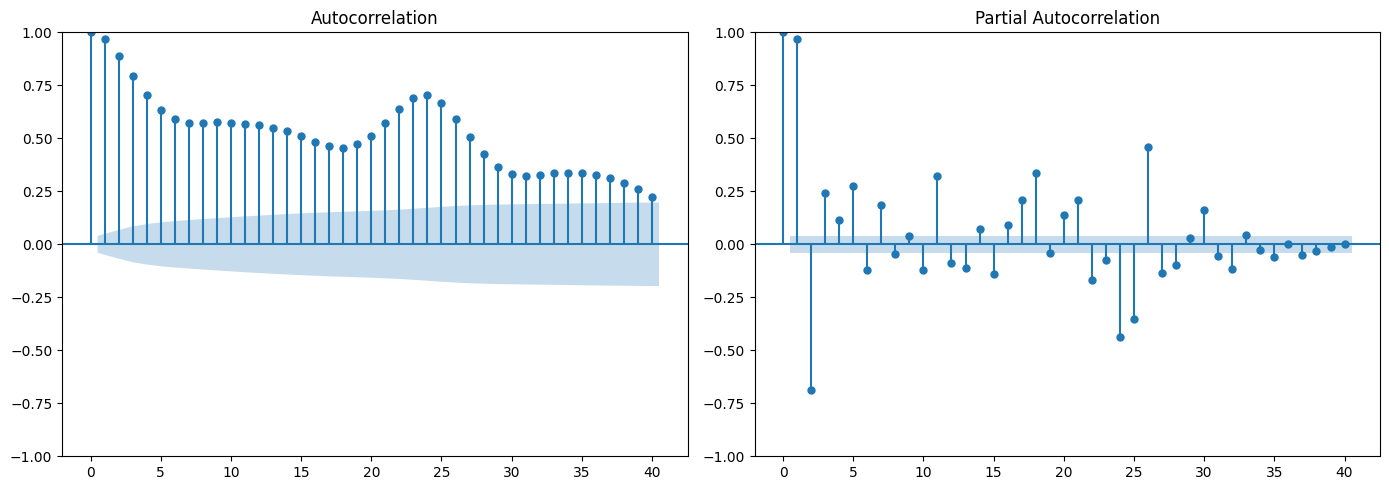

In [93]:

ele = pd.read_csv("data/ele_val_output_7.csv").iloc[:,1:].values.flatten() / 10000
ele=ele[:24*100]
plt.figure(figsize=(20,5))
plt.plot(ele)
plt.title("Electricity Data")
plt.show()

plt.figure(figsize=(20,5))
plt.plot(ele[:24*7])
plt.title("1weeks")
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(121)
plot_acf(ele, lags=40, ax=plt.gca())
plt.subplot(122)
plot_pacf(ele, lags=40, ax=plt.gca())
plt.tight_layout()
plt.show()


---

# 계절차분과 추세차분

/tmp/ipykernel_816173/1174062422.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


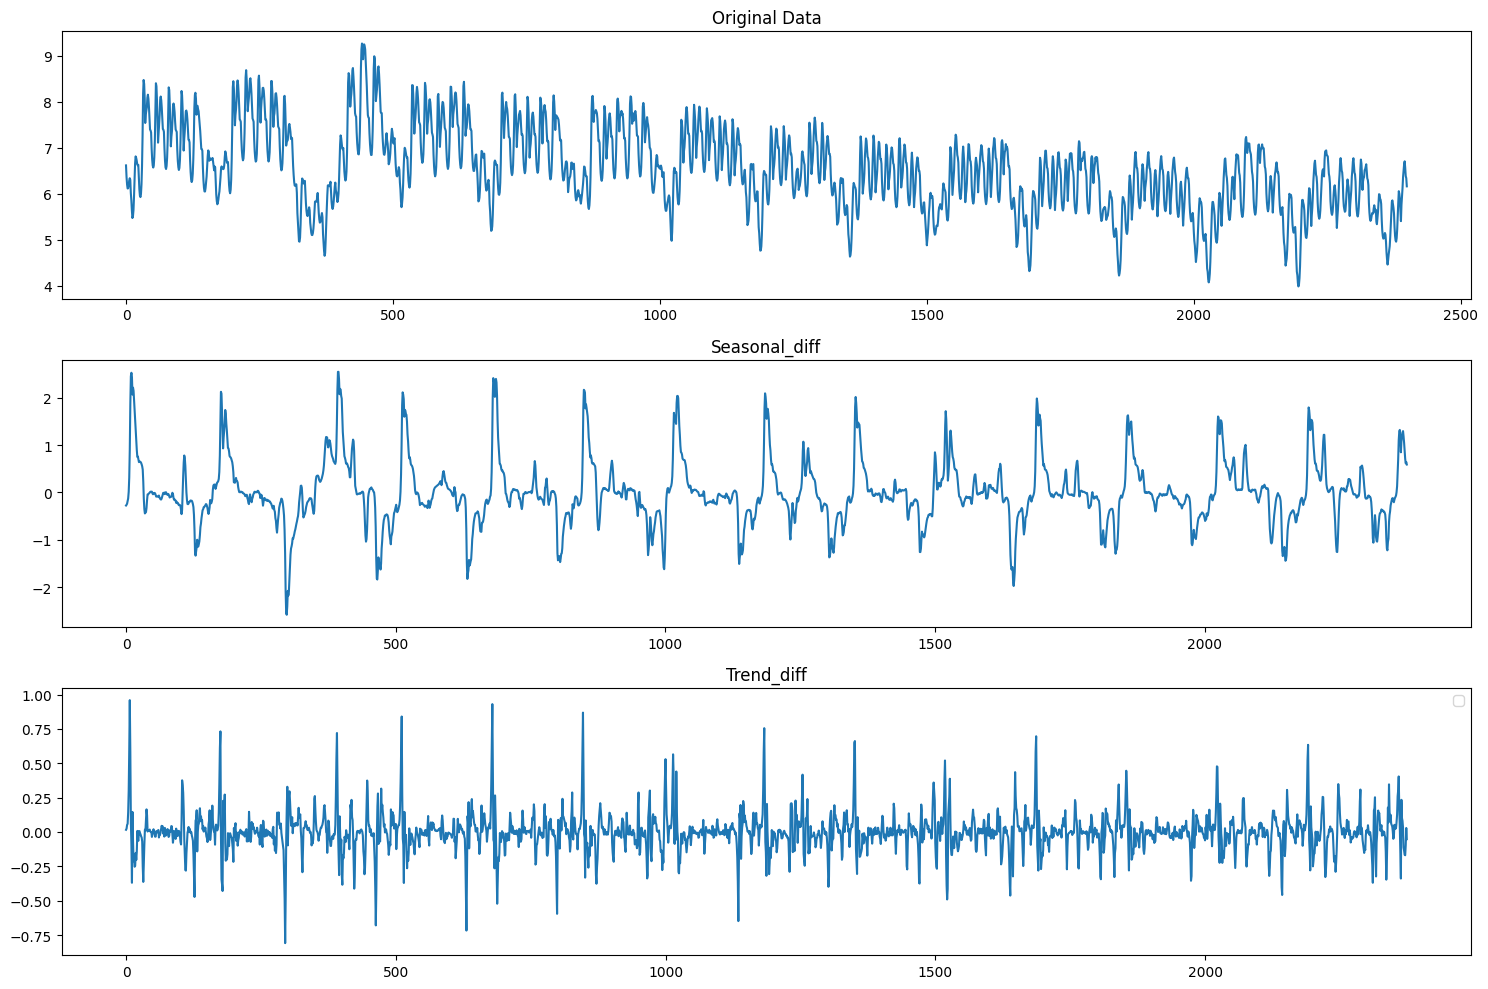

In [94]:
# 계절 차분과 추세 차분 적용
seasonal_diff = ele[24:] - ele[:-24]

trend_diff = seasonal_diff[1:] - seasonal_diff[:-1]
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(ele)
plt.title("Original Data")

plt.subplot(3, 1, 2)
plt.plot(seasonal_diff)
plt.title("Seasonal_diff")


plt.subplot(3, 1, 3)
plt.plot(trend_diff)
plt.title("Trend_diff")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()



---
# 원시계열과 차분된 시계열의 이분산성, 정상성, 독립성 확인

In [95]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.diagnostic import acorr_ljungbox

# OLS 모델 적합 
X = sm.add_constant(range(len(ele))) 
model = sm.OLS(ele, X).fit()

# 이분산성 확인
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_stat, bp_pvalue = bp_test[0], bp_test[1]

# 정규성 확인
shapiro_stat, shapiro_pvalue = stats.shapiro(ele)


# 잔차의 자기상관 평가
dw_stat = durbin_watson(ele)

# 결과 출력
print('################################################################################')
print('original_data')

print(f"Breusch-Pagan Test:\nStatistic: {bp_stat}, p-value: {bp_pvalue}\n")
print(f"Shapiro-Wilk Test:\nStatistic: {shapiro_stat}, p-value: {shapiro_pvalue}\n")
print(f"Durbin-Watson Test:\nDW-statistic: {dw_stat}\n")


X = sm.add_constant(range(len(trend_diff))) 
model = sm.OLS(trend_diff, X).fit()

# 이분산성 확인
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_stat, bp_pvalue = bp_test[0], bp_test[1]

# 정규성 확인
shapiro_stat, shapiro_pvalue = stats.shapiro(trend_diff)


# 잔차의 자기상관 평가
dw_stat = durbin_watson(trend_diff)

# 결과 출력
print('################################################################################')
print('diff_data')


print(f"Breusch-Pagan Test:\nStatistic: {bp_stat}, p-value: {bp_pvalue}\n")
print(f"Shapiro-Wilk Test:\nStatistic: {shapiro_stat}, p-value: {shapiro_pvalue}\n")
print(f"Durbin-Watson Test:\nDW-statistic: {dw_stat}\n")

################################################################################
original_data
Breusch-Pagan Test:
Statistic: 103.1252530463159, p-value: 3.146151026175556e-24

Shapiro-Wilk Test:
Statistic: 0.9968299011741791, p-value: 6.80491655131107e-05

Durbin-Watson Test:
DW-statistic: 0.001188569109135842

################################################################################
diff_data
Breusch-Pagan Test:
Statistic: 6.388351558818922, p-value: 0.011487165594508568

Shapiro-Wilk Test:
Statistic: 0.8709104201336422, p-value: 1.5701580024089392e-40

Durbin-Watson Test:
DW-statistic: 0.6038234708531949



- 원시계열은  bptest, shapiro test 영가설 기각으로 이분산성, 비정규성을 보임, 비독립성을 보임
- 차분된 시계열은 bptest, shapiro test 영가설 기각으로 이분산성, 비정규성, 원시계열에 비해 독립성을 보임

---
# ARIMA 적합
- 수동적합과 오토적합 비교

In [112]:

sarima_model = sm.tsa.statespace.SARIMAX(ele[:-24], 
                                         order=(2, 1, 0),  # 비계절적 (p, d, q)
                                         seasonal_order=(2, 0, 0, 24))
sarima_fit = sarima_model.fit()

# SARIMA 적합 결과 요약 출력
print(sarima_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.38193D-01    |proj g|=  4.27109D+00


 This problem is unconstrained.



At iterate    5    f= -9.84958D-01    |proj g|=  5.84842D-02

At iterate   10    f= -9.86845D-01    |proj g|=  5.32369D-01

At iterate   15    f= -9.87764D-01    |proj g|=  3.89698D-02

At iterate   20    f= -9.87853D-01    |proj g|=  1.11774D-02

At iterate   25    f= -9.87923D-01    |proj g|=  2.16786D-02

At iterate   30    f= -9.87930D-01    |proj g|=  2.62079D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     44      1     0     0   1.048D-06  -9.879D-01
  F = -0.98792971361664417     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Result

---

In [97]:
from pmdarima import auto_arima

# auto_arima로 최적 모델 탐색
auto_model = auto_arima(ele[:-24], 
                        seasonal=True,  # 계절성 고려
                        m=24,  # 계절 주기 설정 (여기서는 24로 설정)
                        trace=True,  # 모델 탐색 과정 표시
                        stepwise=True,  # 빠르게 탐색
                        suppress_warnings=True)

# auto_arima 적합 결과 출력
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-4815.385, Time=10.76 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-289.157, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=6.13 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-3305.240, Time=4.37 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-291.149, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=-3669.988, Time=9.52 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=-4695.768, Time=11.48 sec
 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=-4944.965, Time=45.62 sec
 ARIMA(2,1,2)(2,0,0)[24] intercept   : AIC=-4712.056, Time=39.35 sec
 ARIMA(2,1,2)(2,0,2)[24] intercept   : AIC=inf, Time=43.92 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=inf, Time=42.44 sec
 ARIMA(1,1,2)(2,0,1)[24] intercept   : AIC=inf, Time=38.11 sec
 ARIMA(2,1,1)(2,0,1)[24] intercept   : AIC=inf, Time=41.33 sec
 ARIMA(3,1,2)(2,0,1)[24] intercept   : AIC=-4838.985, Time=46.07 sec
 ARIMA(2,1,3)(2,0,1)[24] int

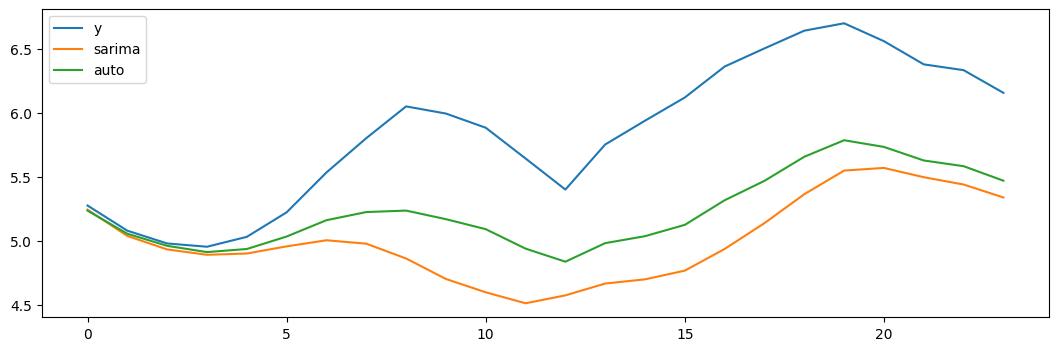

In [113]:
sarima_forecast = sarima_fit.forecast(steps=24)
auto_forecast = auto_model.predict(n_periods=24)


plt.figure(figsize=(13,4))
plt.plot(ele[-24:], label='y')
plt.plot(sarima_forecast, label='sarima')
plt.plot(auto_forecast, label='auto')
plt.legend()
plt.show()
